# Segmentation map으로 도로 이미지 만들기

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1.데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.  
(어떠한 방법을 사용했는지 적어주세요.)  
2.이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.  
3.모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.  
4.1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.  
5.모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

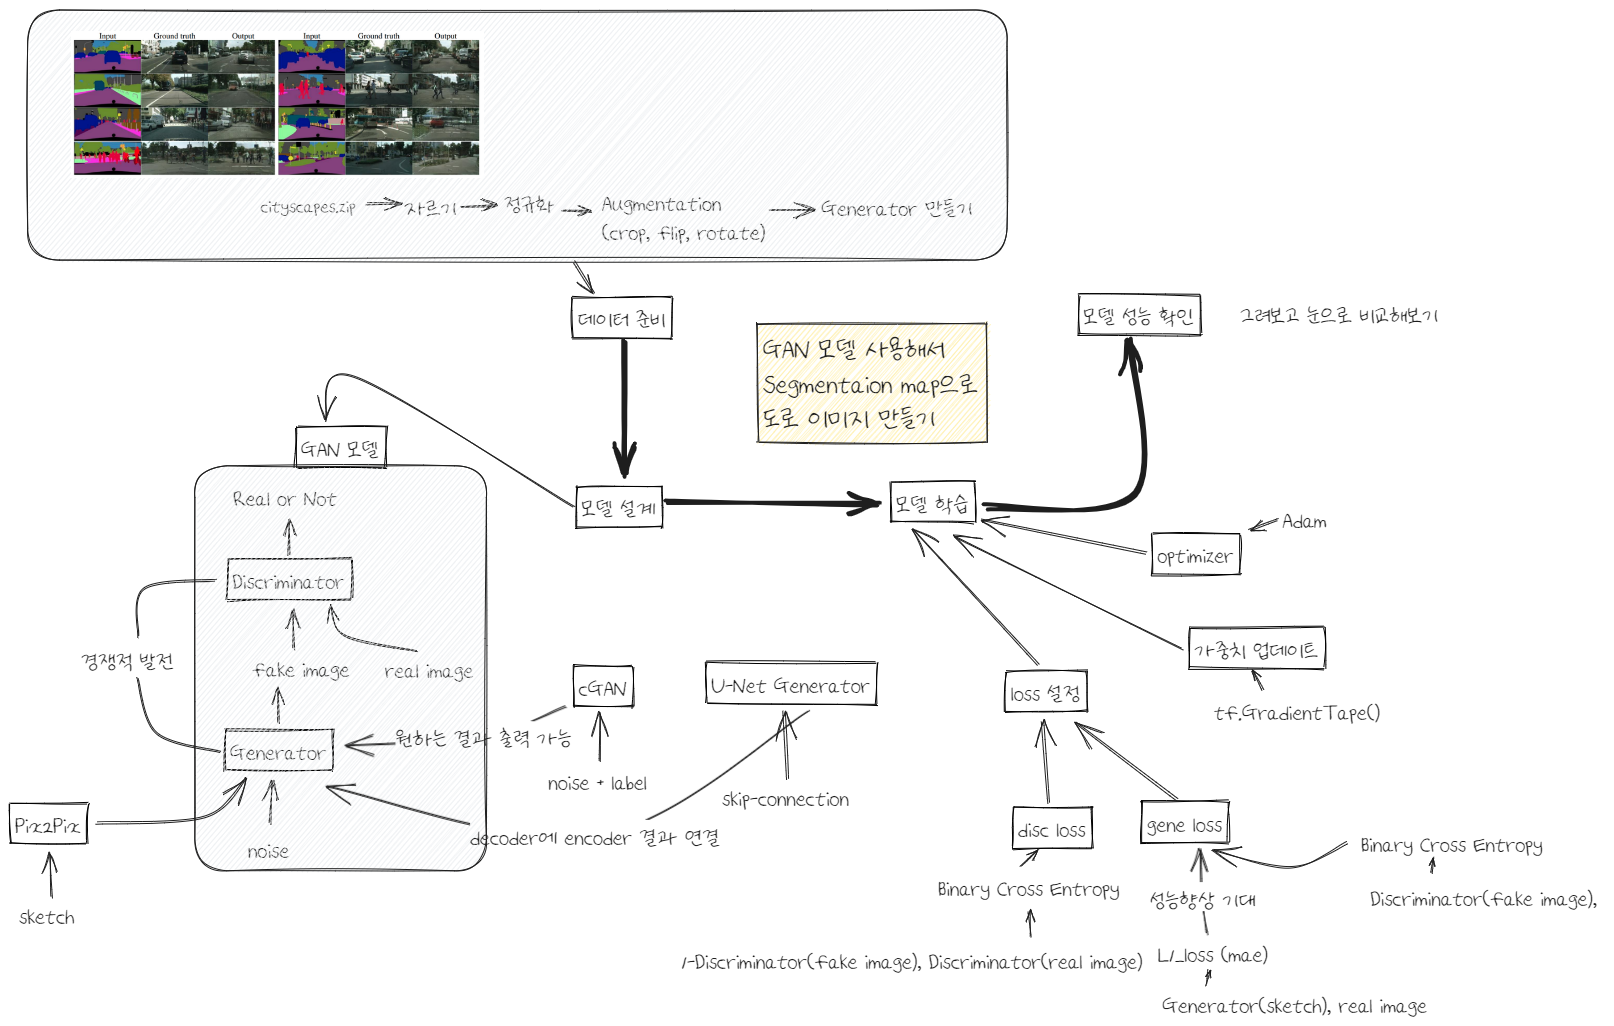

# 데이터 준비하기

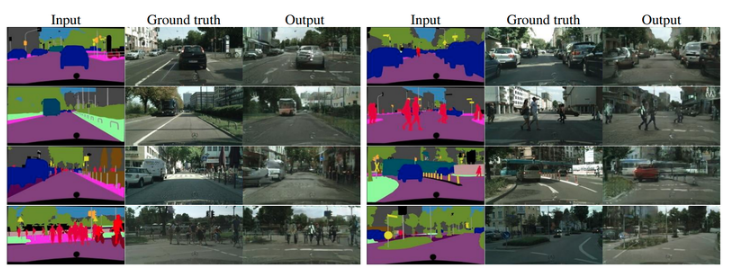

In [2]:
# 사용하는 데이터
import os

train_path = './data/cityscapes/train/'
val_path = './data/cityscapes/val/'

print(f"train 개수 : {len(os.listdir(train_path))}")
print(f"val 개수 : {len(os.listdir(val_path))}")

train 개수 : 1000
val 개수 : 5


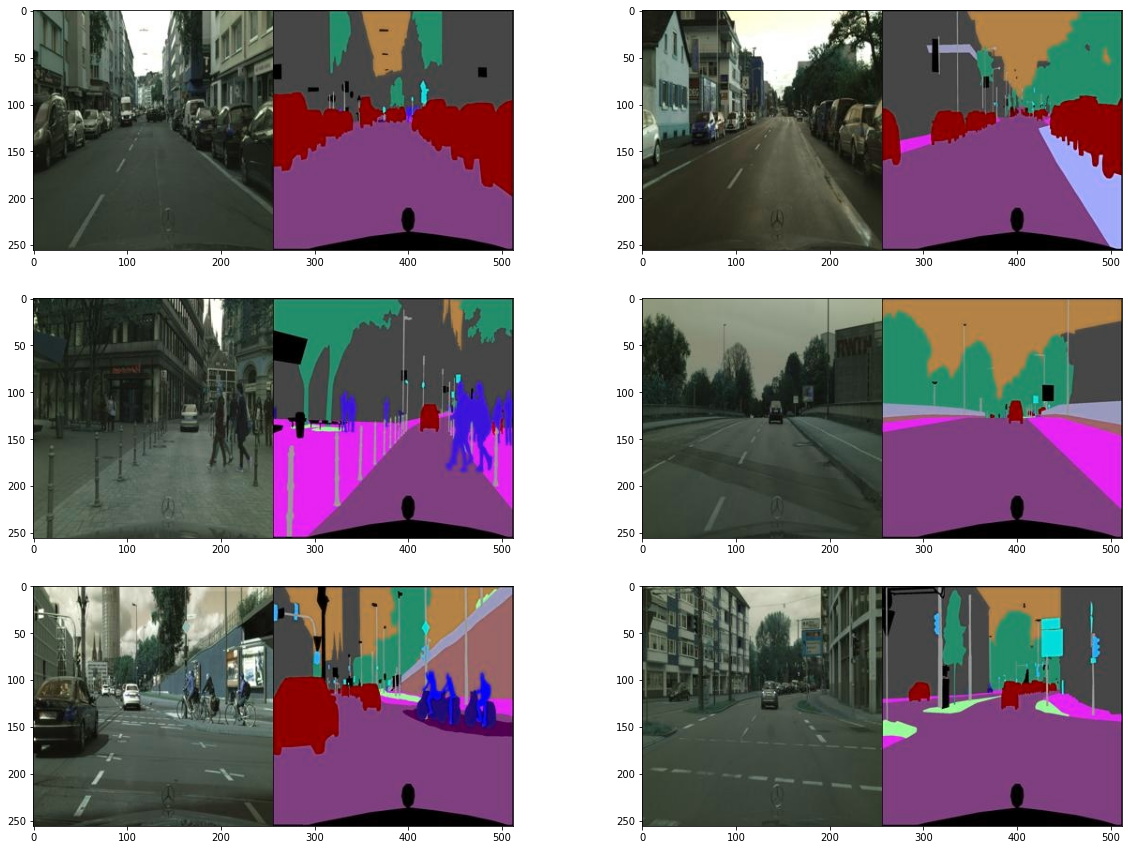

In [3]:
# 데이터 출력해보기
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 모양은?
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


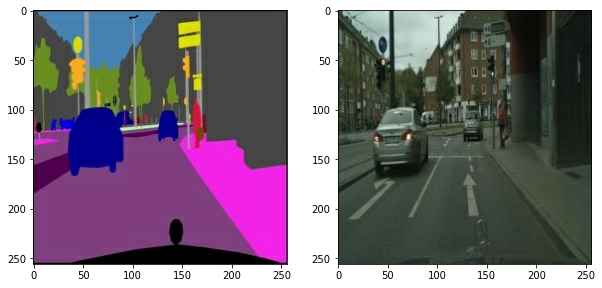

In [5]:
# 데이터 전처리 함수 정의하기
import tensorflow as tf

# img -> -1~1
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# -1~1 -> img 
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 이미지 불러오기 -> 자르기 (sketch, colored) -> 정규화 (sketch, colored)
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [6]:
# Augmentation 적용하기
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 

# 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
# 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
# 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
# 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
# 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
# 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

def apply_augmentation(sketch, colored):
    # 두 이미지가 채널 축으로 연결됨
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: # 50%
        padded = tf.pad(stacked, _pad, "REFLECT") # Refection Padding 적용
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # constant padding 적용

    out = image.random_crop(padded, size=[256, 256, 6]) # 임의로 잘라냄
    
    out = image.random_flip_left_right(out) # 50% 확률로 가로로 뒤집음
    out = image.random_flip_up_down(out) # 50% 확률로 세로로 뒤집음
    
    if tf.random.uniform(()) < .5: # 50%
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 회전 시킴
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


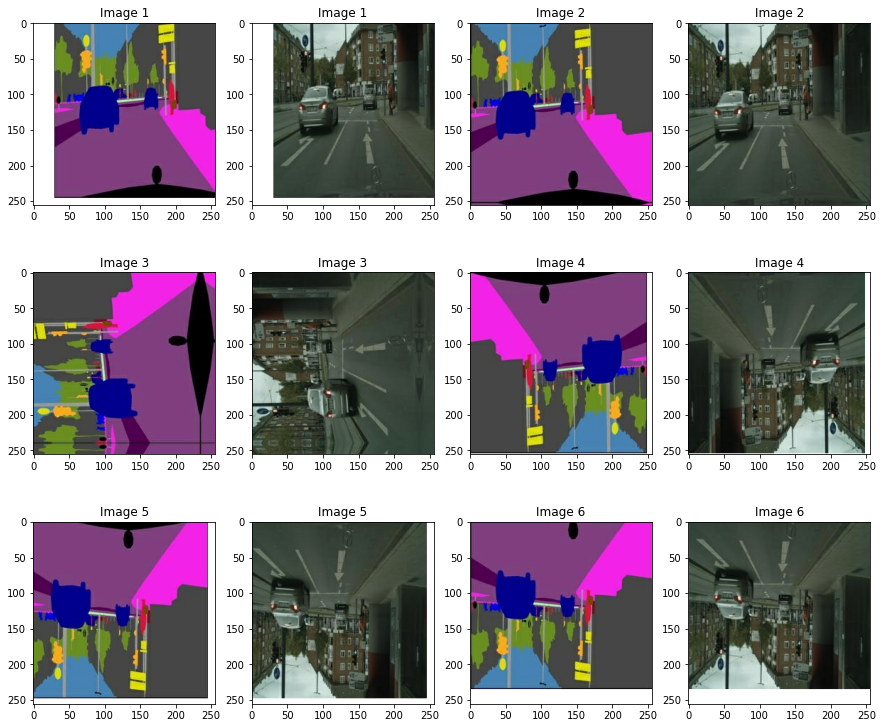

In [7]:
# Augmentation 적용한 결과 살펴보기
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

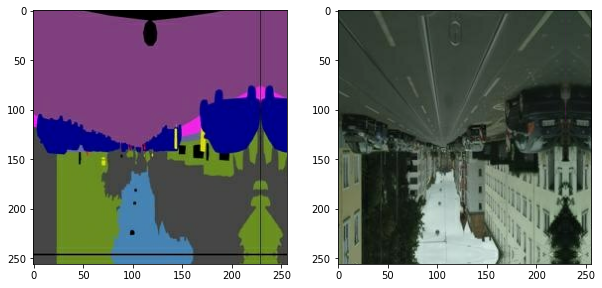

In [8]:
# 데이터 생성용 generator 만들기
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 모델 설계

In [9]:
# Generator 만들기

# Encoder Block
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

# Decoder Block
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
# UNetGenerator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        # skip connection을 위해 features라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 마지막 출력은 bottle neck으로 skip connection의 대상이 아님
        
        # Encoder의 최종 출력물이 decoder를 통과할 때 feature와 연결되어 다음 블록의 입력으로 사용됨
        for block, feat in zip(self.decode_blocks, features[::-1]): # 담긴 순서의 반대로 적용해야 됨
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
# Discriminator 만들기

# Disc Block
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 
    
# Discriminator
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(n_filters=f,
                                         stride=2 if i < 3 else 1, 
                                         custom_pad=False if i < 3 else True, 
                                         use_bn=False if i < 5 else True, 
                                         act=True if i < 5 else False))
        self.sigmoid = layers.Activation(activation='sigmoid')
    
    
    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

# 모델 학습

In [25]:
# loss 설정하기
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    """
    fake_output: 생성한 가짜 이미지
    real_out : 진짜 이미지
    fake_disc : Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값  
    """
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    """
    fake_disc: Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값  
    real_disc: Discriminator에 진짜 이미지를 넣어서 얻은 값
    """
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

# Optimizer 정의하기
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

# 가중치 업데이트 함수 만들기
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape: # 왜 따로 쓰지?
    # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
        fake_images = generator(sketch)
        
        real_disc = discriminator(real_colored, real_colored)
        fake_disc = discriminator(fake_images, real_colored)
        
        gene_loss, l1_loss = get_gene_loss(fake_images, real_colored, fake_disc)
        gen_total_loss = gene_loss + (100 * l1_loss)
        
        disc_loss = get_disc_loss(fake_disc, real_disc)
    
    gene_gradient = gene_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

In [26]:
# 학습 진행하기
EPOCHS = 50
verbose = False

generator = UNetGenerator()
discriminator = Discriminator()

# 결과 저장해서 log 그려보자
g_loss_list = []
l1_loss_list = []
d_loss_list = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images): # batch_size = 4 , 총 250 step
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        g_loss_list.append(g_loss)
        l1_loss_list.append(l1_loss)
        d_loss_list.append(d_loss)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0 and verbose:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    print(f"epoch {epoch} end")

epoch 1 end
epoch 2 end
epoch 3 end
epoch 4 end
epoch 5 end
epoch 6 end
epoch 7 end
epoch 8 end
epoch 9 end
epoch 10 end
epoch 11 end
epoch 12 end
epoch 13 end
epoch 14 end
epoch 15 end
epoch 16 end
epoch 17 end
epoch 18 end
epoch 19 end
epoch 20 end
epoch 21 end
epoch 22 end
epoch 23 end
epoch 24 end
epoch 25 end
epoch 26 end
epoch 27 end
epoch 28 end
epoch 29 end
epoch 30 end
epoch 31 end
epoch 32 end
epoch 33 end
epoch 34 end
epoch 35 end
epoch 36 end
epoch 37 end
epoch 38 end
epoch 39 end
epoch 40 end
epoch 41 end
epoch 42 end
epoch 43 end
epoch 44 end
epoch 45 end
epoch 46 end
epoch 47 end
epoch 48 end
epoch 49 end
epoch 50 end


In [27]:
# 기록 pickle로 저장하기
import pickle

with open('./data/g_loss_list.p', 'wb') as f:
    pickle.dump(g_loss_list, f)
with open('./data/l1_loss_list.p', 'wb') as f:
    pickle.dump(l1_loss_list, f)
with open('./data/d_loss_list.p', 'wb') as f:
    pickle.dump(d_loss_list, f)

# with open("data.p", 'rb') as f:
#     data = pickle.load(f)

In [28]:
# 모델 저장하기
generator.save_weights('./data/map_generator_weight')

os.listdir('./data')

['l1_loss_list.p',
 'd_loss_list.p',
 'map_generator_weight.data-00000-of-00001',
 'g_loss_list.p',
 'cityscapes.zip',
 'map_generator_weight.index',
 'checkpoint',
 'cityscapes']

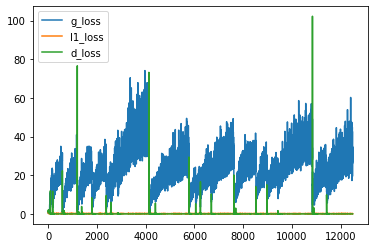

In [29]:
# log 그려보기

plt.plot(g_loss_list, label='g_loss')
plt.plot(l1_loss_list, label='l1_loss')
plt.plot(d_loss_list, label='d_loss')
plt.legend()

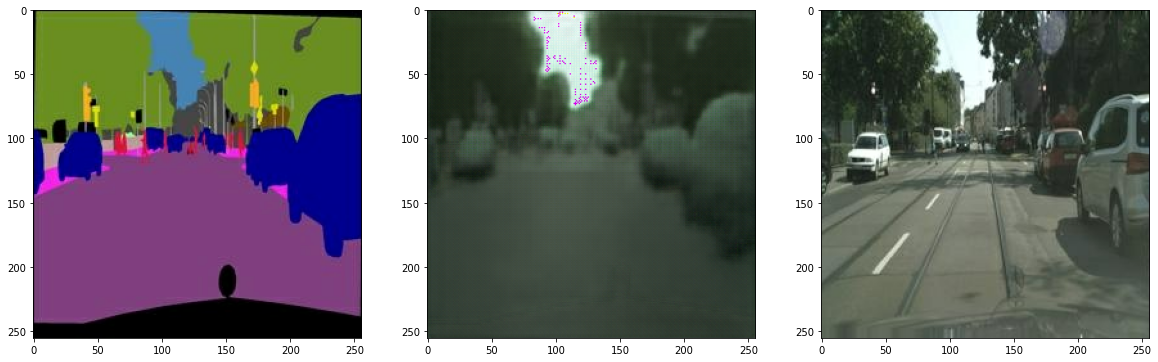

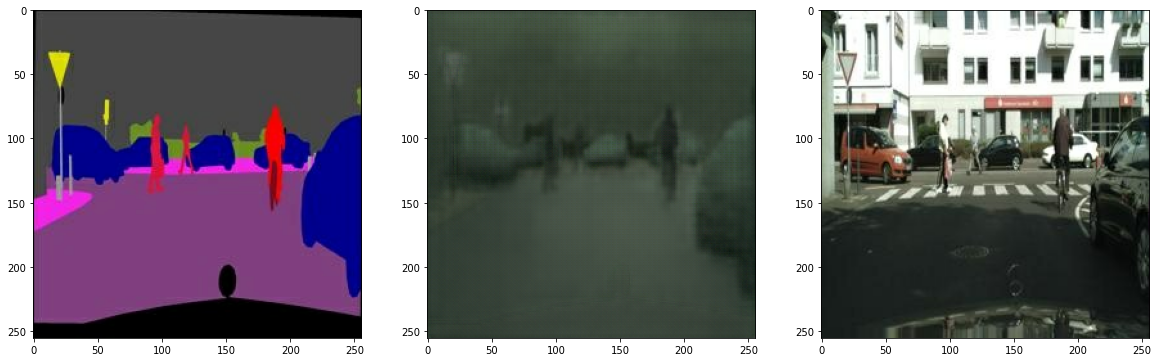

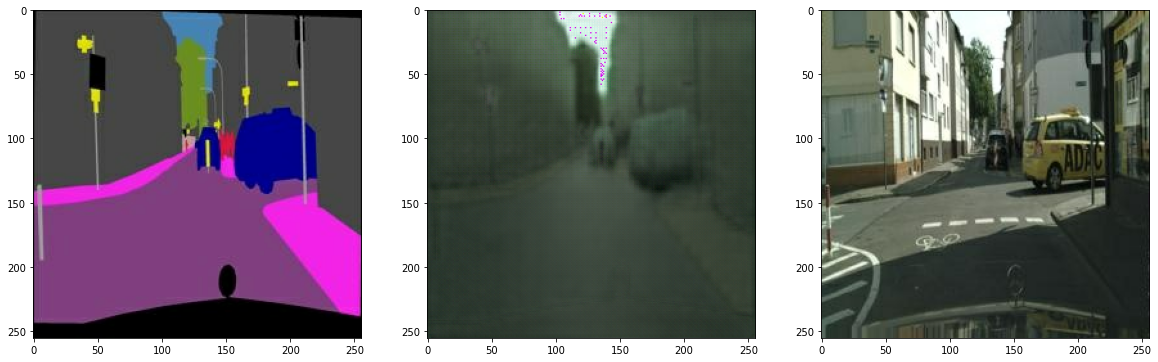

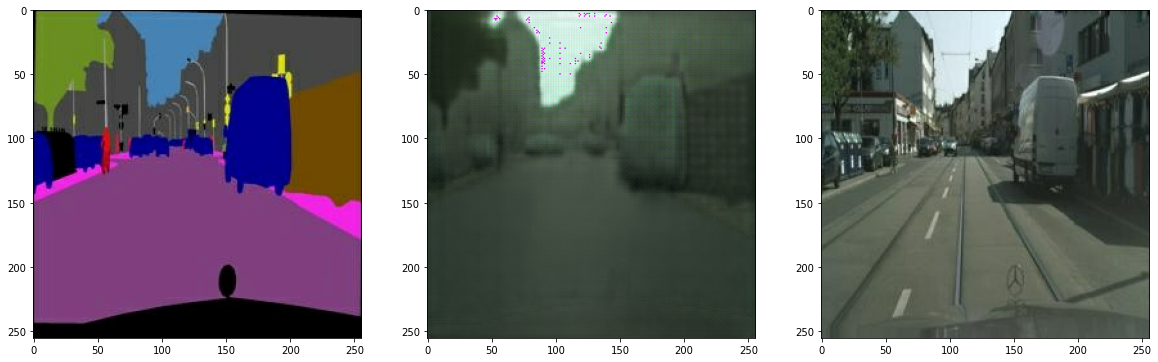

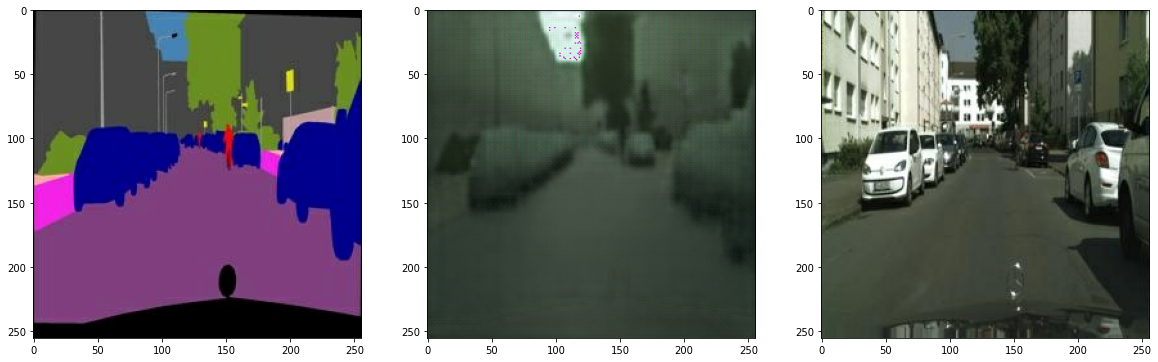

In [30]:
# 테스트 해보기
for i in range(len(os.listdir(val_path))):
    f = val_path + os.listdir(val_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)
 
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

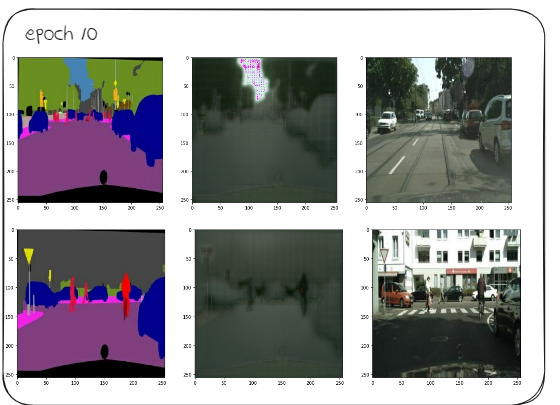
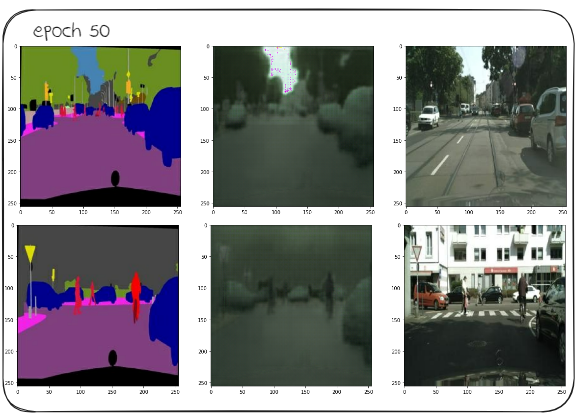  
-> epoch을 높여봐도 큰 차이는 안보인다